# Load trained models and generated trajectories from Wandb
You will need to: 
1. Enroll in Wandb project `foundational_ssm_nlb`
2. Check runs in the project for all trained models. 
3. Download the original dataset from huggingface `https://huggingface.co/datasets/MelinaLaimon/nlb_processed/tree/main`, 

In [6]:
import wandb 
# from foundational_ssm.models import S4DNeuroModel
from foundational_ssm.data_utils import h5_to_dict
from foundational_ssm.data_utils.spikes import smooth_spikes
import matplotlib.pyplot as plt
import torch
import os
import h5py
import pandas as pd
import numpy as np

# Load Model

In [2]:
api = wandb.Api()
wandb_account = "melinajingting-ucl"
project = "foundational_ssm_nlb"
run_name = "nlb_decoding_s4d_l2_d64" # Change this to the desired run name
version = "latest"

model_artifact_full_name = f"{wandb_account}/{project}/{run_name}_best_model:{version}"
model_artifact = api.artifact(model_artifact_full_name, type="model")
model_artifact_dir = model_artifact.download()

model_filename = os.path.join(model_artifact_dir, 'best_model.pt')
torch_state_dict = torch.load(model_filename)
model = S4DNeuroModel(**model_artifact.metadata)
model = model.load_state_dict(torch_state_dict)

wandb:   1 of 1 files downloaded.  


# Load Predictions and Activations

In [3]:
pred_act_artifact_full_name = f"{wandb_account}/{project}/{run_name}_predictions_and_activations:{version}"
pred_act_artifact = api.artifact(pred_act_artifact_full_name, type="predictions")
pred_act_artifact_dir = pred_act_artifact.download()
pred_act_filename = os.path.join(pred_act_artifact_dir, 'predictions_and_activations.h5')

with h5py.File(pred_act_filename, 'r') as h5obj:
    # Use existing h5_to_dict to load as numpy arrays
    predictions_and_activations = h5_to_dict(h5obj)
    predicted_behavior = predictions_and_activations['predictions']
    activations = predictions_and_activations['activations']

wandb: Downloading large artifact nlb_decoding_s4d_l2_d64_predictions_and_activations:latest, 318.68MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:5.2 (61.3MB/s)


# Load original dataset 
1. First, download the data from https://huggingface.co/MelinaLaimon/nlb_processed/tree/main 

In [7]:
input_data_folder = '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb' # Change to where you placed the processed input data
dataset_name = "mc_maze"
input_data_path = os.path.join(input_data_folder,dataset_name + ".h5")
with h5py.File(input_data_path, 'r') as h5file:
    input_dataset_dict = h5_to_dict(h5file)

spikes = np.concat([
    input_dataset_dict['train_spikes_heldin'], 
    input_dataset_dict['train_spikes_heldout']],axis=2) 
smoothed_spikes = smooth_spikes(spikes, kern_sd_ms=40, bin_width=5)
behavior = input_dataset_dict['train_behavior']


trial_info_path = os.path.join(input_data_folder,dataset_name + ".csv")
trial_info_df = pd.read_csv(trial_info_path)
trial_info_df = trial_info_df[trial_info_df['split'].isin(['train','val'])].reset_index()
train_ids = trial_info_df[trial_info_df['split']=='train'].index.tolist()
val_ids = trial_info_df[trial_info_df['split']=='val'].index.tolist()

In [16]:
total_time_ms = 140*5
total_time_s = total_time_ms/1000

In [19]:
np.max(spikes.sum(axis=1))

np.float32(43.0)

In [20]:
43/total_time_s

61.42857142857143

In [181]:
def plot_positions_summary(behavior, predicted_behavior, trial_info_df, version_to_plot):
    # Create a single figure
    fig, ax = plt.subplots(figsize=(8, 8))
    time_resolution = 0.005
    
    # Parse target positions
    def parse_target_pos(pos_str):
        if isinstance(pos_str, str):
            import re
            nums = re.findall(r'-?\d+', pos_str)
            if len(nums) >= 2:
                return int(nums[0]), int(nums[1])
        return None, None
    
    # Get trial types
    trial_types = np.sort(trial_info_df.trial_type.unique())
    
    # Prepare colormap based on angular position
    cmap = plt.cm.hsv
    
    # Collect trajectories by trial type for statistics
    trial_trajectories = {t: {'actual': [], 'predicted': []} for t in trial_types}
    target_positions = {t: (0, 0) for t in trial_types}
    
    # First pass: collect all trajectories and target positions
    for i in trial_info_df.index:
        trial_version = trial_info_df.loc[i, 'trial_version']
        
        if trial_version == version_to_plot:
            trial_type = trial_info_df.loc[i, 'trial_type']
            
            # Get target position for this trial type
            if trial_type in target_positions:
                target_x, target_y = parse_target_pos(trial_info_df.loc[i, 'target_pos'])
                if target_x is not None:
                    target_positions[trial_type] = (target_x, target_y)
            
            # Get velocities and integrate
            trial_velocity = behavior[i]*time_resolution
            trial_predicted_velocity = predicted_behavior[i]*time_resolution
            
            # Calculate positions
            trial_position = np.zeros_like(trial_velocity)
            trial_predicted_position = np.zeros_like(trial_predicted_velocity)
            
            trial_position[:, 0] = np.cumsum(trial_velocity[:, 0])
            trial_position[:, 1] = np.cumsum(trial_velocity[:, 1])
            trial_predicted_position[:, 0] = np.cumsum(trial_predicted_velocity[:, 0])
            trial_predicted_position[:, 1] = np.cumsum(trial_predicted_velocity[:, 1])
            
            # Store trajectories for statistics
            trial_trajectories[trial_type]['actual'].append(trial_position)
            trial_trajectories[trial_type]['predicted'].append(trial_predicted_position)
    
    # Calculate angles for color mapping
    angles = []
    for trial_type in trial_types:
        x, y = target_positions[trial_type]
        angle = np.arctan2(y, x)
        angles.append(angle)
    
    norm_angles = (np.array(angles) + np.pi) / (2 * np.pi)
    
    # Plot mean trajectories and targets for all trial types
    for j, trial_type in enumerate(trial_types):
        color = cmap(norm_angles[j])
        
        # Plot target position
        target_x, target_y = target_positions[trial_type]
        ax.scatter(target_x, target_y, color=color, s=100, marker='*', zorder=5)
        
        # Annotate target with trial type number
        ax.annotate(f'{int(trial_type)}', (target_x, target_y), 
                   xytext=(3, 3), textcoords='offset points', fontsize=8)
        
        # Plot mean trajectories
        if trial_trajectories[trial_type]['actual']:
            # Actual trajectory
            actual_paths = np.array(trial_trajectories[trial_type]['actual'])
            mean_actual = np.mean(actual_paths, axis=0)
            
            ax.plot(mean_actual[:, 0], mean_actual[:, 1], color=color, linewidth=2, alpha=0.7)
            
            # Predicted trajectory
            predicted_paths = np.array(trial_trajectories[trial_type]['predicted'])
            mean_predicted = np.mean(predicted_paths, axis=0)
            
            ax.plot(mean_predicted[:, 0], mean_predicted[:, 1], color=color, 
                  linewidth=2, linestyle='--', alpha=0.7)
    
    # Mark start position
    ax.scatter(0, 0, color='black', s=100, marker='o', label='Start')
    
    # Add legend for trajectory types
    handles = [
        plt.Line2D([0], [0], color='gray', linewidth=2, label='Actual (mean)'),
        plt.Line2D([0], [0], color='gray', linewidth=2, linestyle='--', label='Predicted (mean)'),
        plt.scatter([0], [0], color='black', s=100, marker='o', label='Start'),
        plt.scatter([0], [0], color='gray', s=100, marker='x', label='Target')
    ]
    ax.legend(handles=handles, loc='upper right')
    
    ax.set_title(f'All Trial Types (Version {version_to_plot})')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot the positions. 
Note: There are versions 0,1,2. Arthur mentions this could be center-out vs maze.

# Understanding Trial Info
- There are 36 trial types, and 3 trial versions per type. 
- The trial type determines the target position, plotted below. 
- For trial_version 0 and 1, there's only 1 target. 
- For trial_version 2, there are active targets. I'm not sure yet how that works.

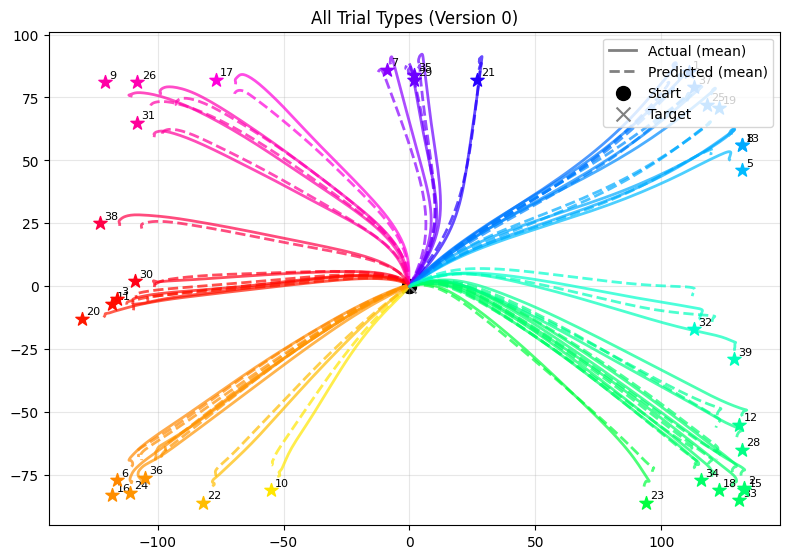

In [182]:
plot_positions_summary(behavior, predicted_behavior, trial_info_df, 0)

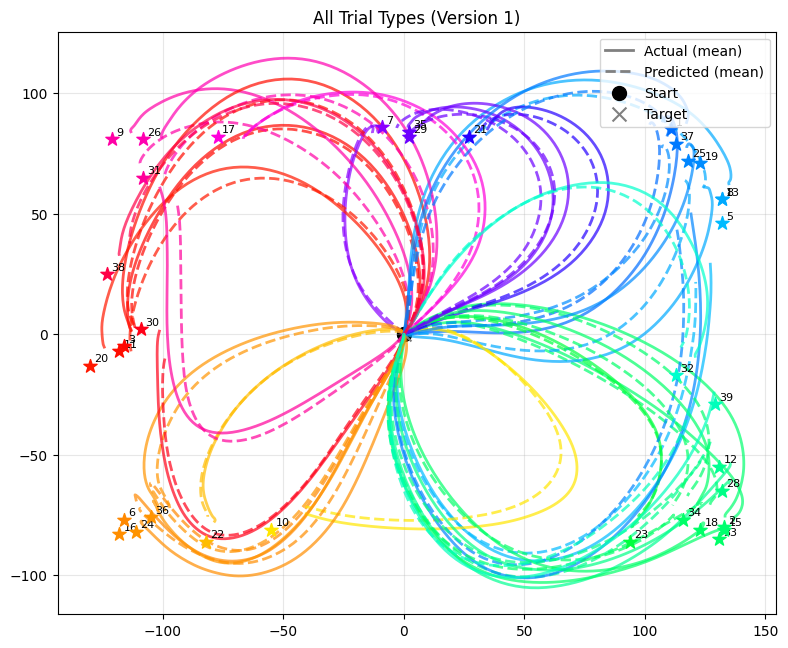

In [183]:
plot_positions_summary(behavior, predicted_behavior, trial_info_df, 1)

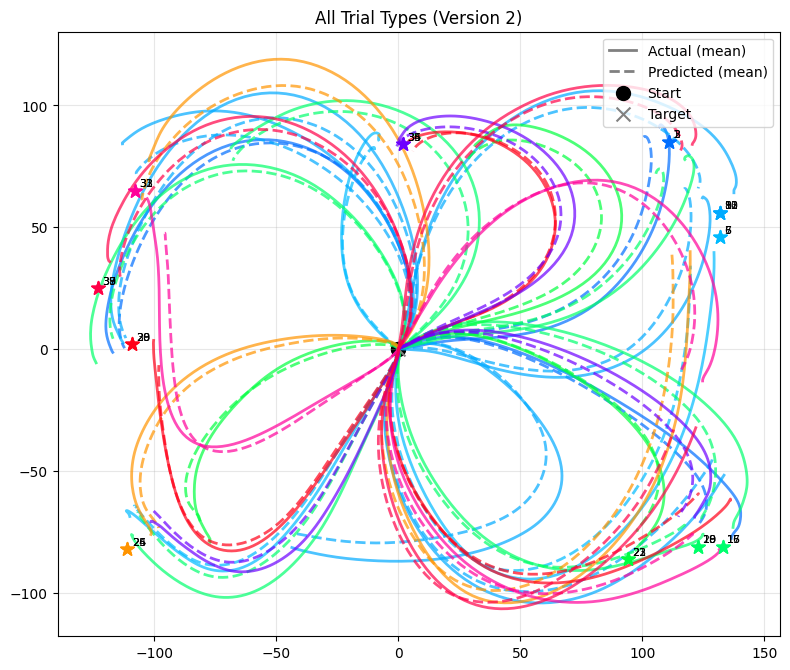

In [184]:
plot_positions_summary(behavior, predicted_behavior, trial_info_df, 2)